In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
import welly
import pandas as pd
import cp_comparitor as cp_Comp
import change_point_tools as cp_Tools
import well_tools as wtool
import test_func as tst

In [2]:
path = 'C:\\Users\\ada55080\\git\different_bayes\\volve_well_data\\'

In [3]:
#setting global variables for the ruptures PELT parameters pen and min_size 
 
f1A = welly.Well.from_las(path + '15_9-F-1A\\15_9-F-1A.las')
f1B = welly.Well.from_las(path + '15_9-F-1B\\15_9-F-1B.las')
f1C = welly.Well.from_las(path + '15_9-F-1C\\15_9-F-1C.las')
f11A = welly.Well.from_las(path + '15_9-F-11A\\15_9-F-11A.las')
f11B = welly.Well.from_las(path + '15_9-F-11B\\15_9-F-11B.las')

Importing libraries and loading Equinor's Offshore Volve oil field data (Open sourced) 

In [4]:
#wtool = well_tools.well_tools()



The following dictionaries are global place holder variables.

In [5]:


#Rolling average parameters

#window = 30
#periods = 3

#setting global variables for the ruptures PELT parameters pen and min_size 
RHOB_glob_pen = 0.5
RHOB_glob_min = 10

NPHI_glob_pen = 0.1
NPHI_glob_min = 10

GR_glob_pen = 1300
GR_glob_min = 10


#string label varables
dataGR = "GR"
dataRHOB = "RHOB"
dataNPHI = "NPHI"

#Well names lists for automation
_wellnames = ['df_f1A', 'df_f1B', 'df_f1C', 'df_f11A', 'df_f11B']
_wells = [f1A, f1B, f1C, f11A, f11B]
_log_list = {'NPHI','RHOB','GR','DT','PEF'}

#Dictionaries for log extents

_logname_extent_min = {'f1A' : 2620, 'f1B' : 3100 , 'f1C': 3100 , 'f11A' : 2600 , 'f11B': 3200 }
_logname_extent_max = {'f1A' : 3600, 'f1B' : 3400 , 'f1C': 4100 , 'f11A' : 3700 , 'f11B': 4550 }
_log_extent_min = {0 : 2620, 1 : 3100 , 2: 3100 , 3 : 2600 , 4: 3200 }
_log_extent_max = {0: 3600, 1 : 3400 , 2: 4100 , 3 : 3700 , 4: 4550 }

In [6]:
# Writing well log values to dataframe, index is MD(measured depth)
df_f1A = _wells[0].df(_log_list)
df_f1B = _wells[1].df(_log_list)
df_f1C = _wells[2].df(_log_list)
df_f11A = _wells[3].df(_log_list)
df_f11B = _wells[4].df(_log_list)

data_f1A = wtool.compute_all_rolling_avg(df_f1A, window=30, periods=3)
data_f1B = wtool.compute_all_rolling_avg(df_f1B, window=30, periods=3)
data_f1C = wtool.compute_all_rolling_avg(df_f1C, window=30, periods=3)
data_f11A = wtool.compute_all_rolling_avg(df_f11A, window=30, periods=3)
data_f11B = wtool.compute_all_rolling_avg(df_f11B, window=30, periods=3)


# #NaN handling (simple dataset average replaces all NaN's)
# string = 'rollNPHI'
# datalabel = 'NPHI'
# df= pd.DataFrame()
# df[string] = df_f1A[datalabel].rolling(30, min_periods=3).mean()
# col= pd.DataFrame(df_f11A).columns.unique()
# #col = df_f1A.columns.unique()
# for i in col:
#     print(i)
# df[3400:3410]
# datalabel = 'NPHI'
# #dataroll = wtool.df_rolling_avg(df_f1A, 'NPHI', periods=30)

In [7]:
data_f11A

,RHOB,NPHI,PEF,DT,GR,Roll_Avg_RHOB,Roll_Avg_NPHI,Roll_Avg_PEF,Roll_Avg_DT,Roll_Avg_GR
DEPTH,,,,,,,,,,
188.5000000000,NaN,NaN,NaN,NaN,4.300,NaN,NaN,NaN,NaN,NaN
188.6000000000,NaN,NaN,NaN,NaN,3.801,NaN,NaN,NaN,NaN,NaN
188.7000000000,NaN,NaN,NaN,NaN,4.301,NaN,NaN,NaN,NaN,4.1340
188.8000000000,NaN,NaN,NaN,NaN,4.600,NaN,NaN,NaN,NaN,4.2505
188.9000000000,NaN,NaN,NaN,NaN,4.599,NaN,NaN,NaN,NaN,4.3202
...,...,...,...,...,...,...,...,...,...,...
3761.4999999968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3761.5999999968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3761.6999999968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding breakpoint and trends for Volve input, using PELT search algorythm in this example... it is an offline method that produces a discrete breakpoint. Trend values are the mean for the data sections between breakpoints. Future implementations will include a variety of search funcitons, with probability and ranges for this search.

In [35]:
_log_choice = 'Roll_Avg_PEF'
pennum = 40
minsiz = 10


f1A_PEFmu, f1A_PEFbp = cp_Comp.piecewise_linearRegress(data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]].to_numpy(), pen=pennum, min_size=minsiz)
f1B_PEFmu, f1B_PEFbp = cp_Comp.piecewise_linearRegress(data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]].to_numpy(), pen=pennum, min_size=minsiz)
f1C_PEFmu, f1C_PEFbp = cp_Comp.piecewise_linearRegress(data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]-70].to_numpy(), pen=pennum, min_size=minsiz)
f11A_PEFmu, f11A_PEFbp = cp_Comp.piecewise_linearRegress(data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]].to_numpy(), pen=pennum, min_size=minsiz)
f11B_PEFmu, f11B_PEFbp = cp_Comp.piecewise_linearRegress(data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]].to_numpy(), pen=pennum, min_size=minsiz)

13 [   0. 1520. 3725. 6085. 6685. 7150. 7490. 7790. 7975. 8115. 8160. 8465.
 9800.]
[0.         5.09759695 7.86613315 7.5109809  7.07503962 6.49939313
 7.60775463 6.65670544 7.58152411 6.71773138 9.06036748 5.46160863
 5.94529523]
9 [   0.  255. 1045. 1185. 1415. 1465. 2045. 2130. 3000.]
[0.         7.60595876 6.94353425 6.0008024  6.85414878 8.7788506
 5.60680571 7.09069659 6.13486678]
26 [   0.  570.  860. 1155. 1315. 1560. 1805. 2430. 3205. 3725. 4315. 4445.
 4565. 4740. 5155. 5390. 6120. 6150. 6465. 6560. 6605. 7030. 7975. 8195.
 9030. 9300.]
[0.         7.6109513  6.92453722 7.9976373  7.08038556 6.08222888
 5.31632023 6.62420697 5.6380471  6.34283649 5.29602019 6.241084
 5.26104453 6.42940253 5.6394978  4.88002074 5.42282623 6.68632867
 4.78400795 5.60403803 8.30151341 4.886827   5.36826422 6.11160238
 5.43042481 6.8075767 ]
19 [    0.   100.   250.  1065.  1255.  1435.  1540.  1950.  5770.  6965.
  8615.  9060.  9260.  9575.  9610.  9905.  9960. 10655. 11000.]
[0.         5.8181

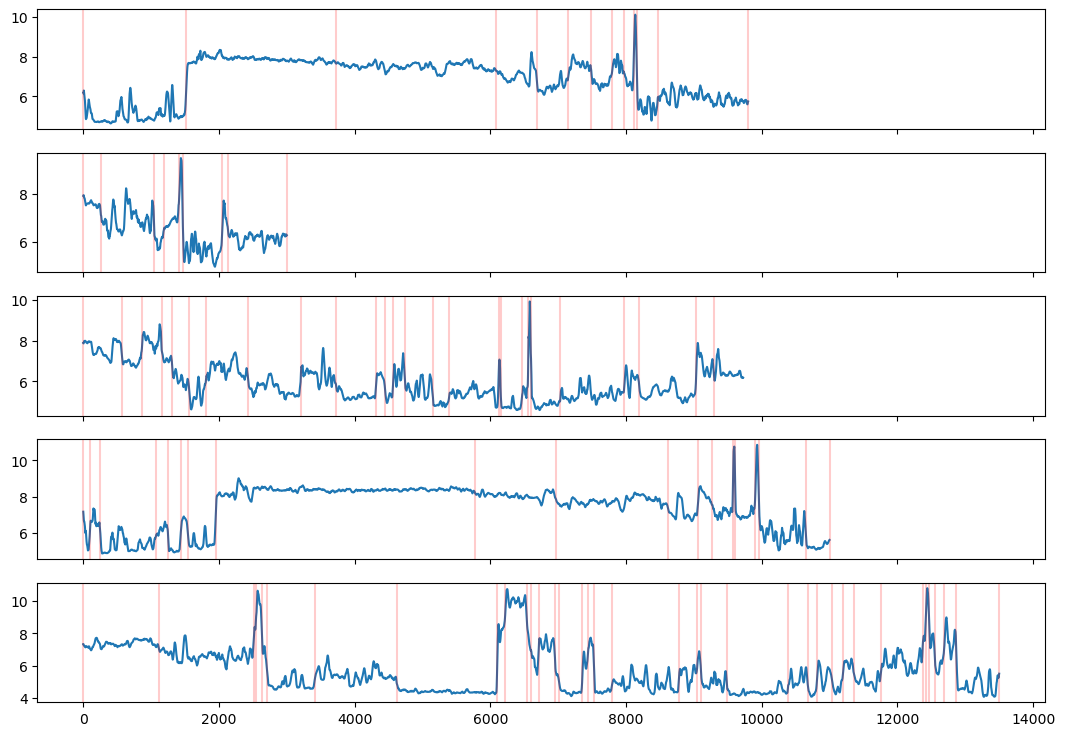

In [36]:
fig, ax = plt.subplots(5, figsize=[13, 9], sharex=True)

_log_choice = 'Roll_Avg_PEF'
len(data_f1A[_log_extent_min[0]:_log_extent_max[0]])
ax[0].plot(np.arange(len(data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]])), data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]])
for i in f1A_PEFbp:
    ax[0].axvline(i, c='r', alpha=0.2)
ax[1].plot(np.arange(len(data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]])), data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]])
for i in f1B_PEFbp:
    ax[1].axvline(i, c='r', alpha=0.2)
ax[2].plot(np.arange(len(data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]])), data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]])
for i in f1C_PEFbp:
    ax[2].axvline(i, c='r', alpha=0.2)
ax[3].plot(np.arange(len(data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]])), data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]])
for i in f11A_PEFbp:
    ax[3].axvline(i, c='r', alpha=0.2)
ax[4].plot(np.arange(len(data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]])), data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]])
for i in f11B_PEFbp:
    ax[4].axvline(i, c='r', alpha=0.2)

In [8]:
_log_choice = 'Roll_Avg_NPHI'
pennum = 0.3
minsiz = 10

#NPHI

f1A_NPHImu, f1A_NPHIbp = cp_Comp.piecewise_linearRegress(data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]].to_numpy(), pen=pennum, min_size=minsiz)
f1B_NPHImu, f1B_NPHIbp = cp_Comp.piecewise_linearRegress(data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]].to_numpy(), pen=pennum, min_size=minsiz)
f1C_NPHImu, f1C_NPHIbp = cp_Comp.piecewise_linearRegress(data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]-70].to_numpy(), pen=pennum, min_size=minsiz)
f11A_NPHImu, f11A_NPHIbp = cp_Comp.piecewise_linearRegress(data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]].to_numpy(), pen=pennum, min_size=minsiz)
f11B_NPHImu, f11B_NPHIbp = cp_Comp.piecewise_linearRegress(data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]].to_numpy(), pen=pennum, min_size=minsiz)

18 [   0.  520.  795. 1540. 1680. 2300. 3685. 4385. 5155. 5755. 7150. 7385.
 7790. 7970. 8160. 8655. 9265. 9800.]
[0.         0.24014083 0.29967659 0.25021347 0.1932794  0.13397296
 0.07080634 0.11843025 0.07642712 0.11867274 0.14673052 0.20586786
 0.42945248 0.48026967 0.33388784 0.19562459 0.12217989 0.16283398]
9 [   0.  605.  695. 1015. 1220. 1470. 2050. 2270. 3000.]
[0.         0.15064523 0.21558315 0.44033746 0.32409928 0.25547812
 0.17657756 0.10295224 0.15990907]
15 [   0. 1075. 1140. 1295. 2635. 2875. 3510. 4315. 4690. 6065. 6660. 7485.
 7985. 9060. 9300.]
[0.         0.16345536 0.46053523 0.31324649 0.20736322 0.15039522
 0.23138073 0.18354676 0.14577385 0.20290871 0.13908756 0.17410387
 0.20735547 0.16195856 0.2755936 ]
17 [    0.   260.   405.  1765.  1970.  2195.  3735.  4235.  5195.  6340.
  8305.  9045.  9270.  9595.  9710.  9960. 11000.]
[0.         0.33602205 0.22084644 0.28842039 0.23825707 0.15724844
 0.08629788 0.13209347 0.07452684 0.12435459 0.09132324 0.1550859
 

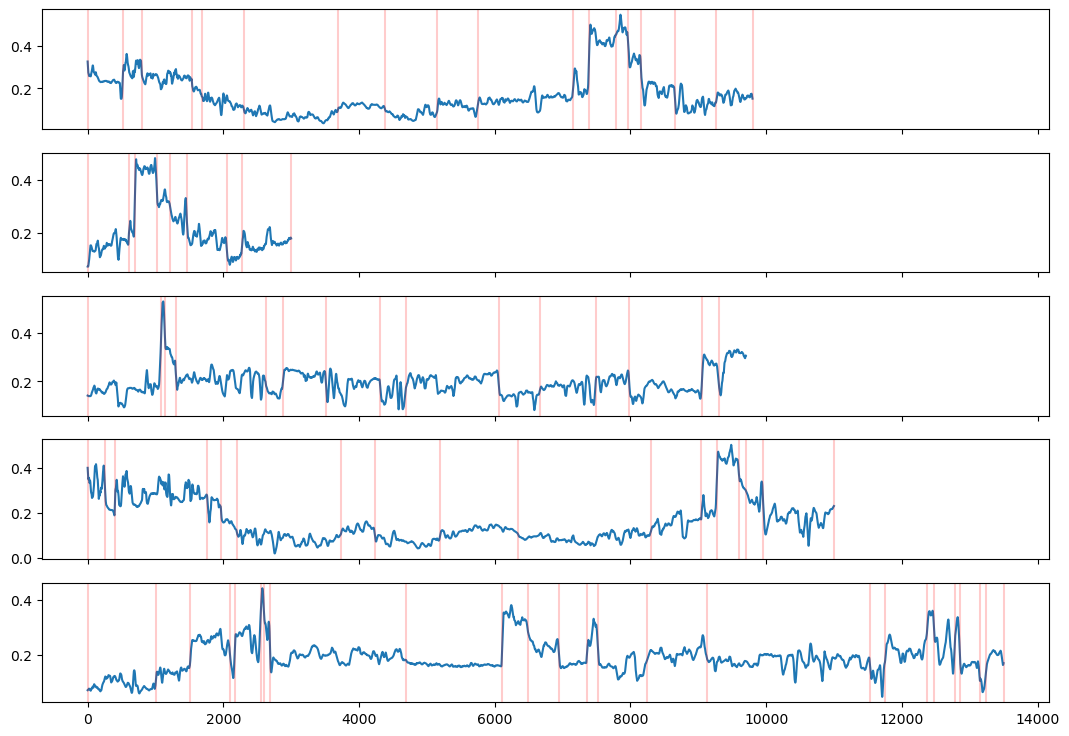

In [11]:
fig, ax = plt.subplots(5, figsize=[13, 9], sharex=True)

_log_choice = 'Roll_Avg_NPHI'
len(data_f1A[_log_extent_min[0]:_log_extent_max[0]])
ax[0].plot(np.arange(len(data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]])), data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]])
for i in f1A_NPHIbp:
    ax[0].axvline(i, c='r', alpha=0.2)
ax[1].plot(np.arange(len(data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]])), data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]])
for i in f1B_NPHIbp:
    ax[1].axvline(i, c='r', alpha=0.2)
ax[2].plot(np.arange(len(data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]])), data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]])
for i in f1C_NPHIbp:
    ax[2].axvline(i, c='r', alpha=0.2)
ax[3].plot(np.arange(len(data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]])), data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]])
for i in f11A_NPHIbp:
    ax[3].axvline(i, c='r', alpha=0.2)
ax[4].plot(np.arange(len(data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]])), data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]])
for i in f11B_NPHIbp:
    ax[4].axvline(i, c='r', alpha=0.2)



In [62]:
_log_choice = 'Roll_Avg_GR'
pennum = 30000
minsiz = 10


f1A_GRmu, f1A_GRbp = cp_Comp.piecewise_linearRegress(data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]].to_numpy(), pen=pennum, min_size=minsiz)
f1B_GRmu, f1B_GRbp = cp_Comp.piecewise_linearRegress(data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]].to_numpy(), pen=pennum, min_size=minsiz)
f1C_GRmu, f1C_GRbp = cp_Comp.piecewise_linearRegress(data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]].to_numpy(), pen=pennum, min_size=minsiz)
f11A_GRmu, f11A_GRbp = cp_Comp.piecewise_linearRegress(data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]].to_numpy(), pen=pennum, min_size=minsiz)
f11B_GRmu, f11B_GRbp = cp_Comp.piecewise_linearRegress(data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]].to_numpy(), pen=pennum, min_size=minsiz)

17 [   0. 1525. 4860. 5750. 6690. 7390. 7405. 7480. 7535. 7750. 7820. 7900.
 7945. 7975. 7985. 8105. 9800.]
[  0.          37.98706503   8.57514576  29.01757565  42.34702568
  59.65968464 169.70490624 273.46985435 198.74781189 235.60999646
 313.96294059 363.3100445  298.3490337  360.33069438 223.52332196
 147.19263997  45.20807284]
9 [   0.  485.  690.  710. 1030. 1225. 1390. 2100. 3000.]
[  0.          40.01435658  58.33567297 145.74052854 232.68399881
 137.71873418 103.11501435  34.25855825  49.30993912]
25 [   0.  445.  565. 1060. 1075. 1110. 1120. 1145. 1155. 1190. 1310. 1790.
 2405. 2885. 3190. 3810. 4890. 5150. 5410. 6060. 6675. 8020. 9055. 9360.
 9939.]
[  0.          44.329439    23.06433583  53.80349445 172.11422493
 266.41790317 330.7636431  473.34299342 329.04371821 162.05434532
 102.74525302  17.22414334  62.92141303  47.44002309  32.39122697
  52.02827561  33.23200889  46.91388176  14.33522845  43.80801356
  11.39871215  38.36302676  21.78749474  66.26230894 112.8370428 ]


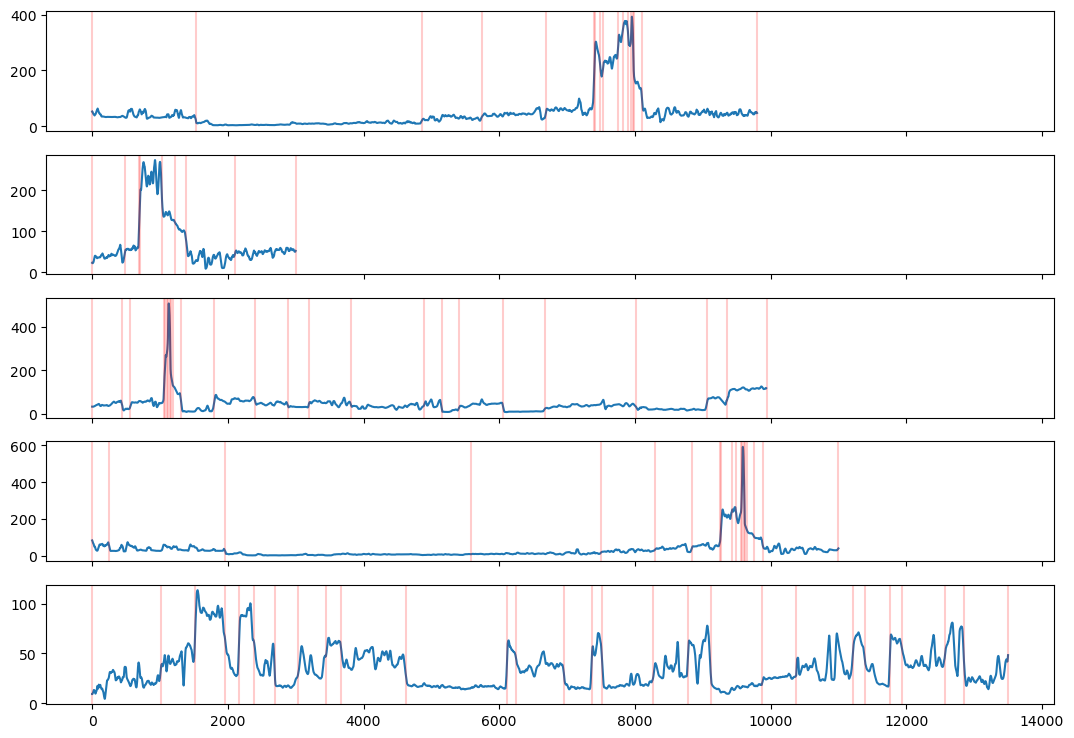

In [63]:
fig, ax = plt.subplots(5, figsize=[13, 9], sharex=True)

_log_choice = 'Roll_Avg_GR'
len(data_f1A[_log_extent_min[0]:_log_extent_max[0]])
ax[0].plot(np.arange(len(data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]])), data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]])
for i in f1A_GRbp:
    ax[0].axvline(i, c='r', alpha=0.2)
ax[1].plot(np.arange(len(data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]])), data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]])
for i in f1B_GRbp:
    ax[1].axvline(i, c='r', alpha=0.2)
ax[2].plot(np.arange(len(data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]])), data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]])
for i in f1C_GRbp:
    ax[2].axvline(i, c='r', alpha=0.2)
ax[3].plot(np.arange(len(data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]])), data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]])
for i in f11A_GRbp:
    
    ax[3].axvline(i, c='r', alpha=0.2)
ax[4].plot(np.arange(len(data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]])), data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]])
for i in f11B_GRbp:
    ax[4].axvline(i, c='r', alpha=0.2)

In [30]:
_log_choice = 'Roll_Avg_RHOB'
pennum = 1
minsiz = 10


f1A_RHOBmu, f1A_RHOBbp = cp_Comp.piecewise_linearRegress(data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]].to_numpy(), pen=pennum, min_size=minsiz)
f1B_RHOBmu, f1B_RHOBbp = cp_Comp.piecewise_linearRegress(data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]].to_numpy(), pen=pennum, min_size=minsiz)
f1C_RHOBmu, f1C_RHOBbp = cp_Comp.piecewise_linearRegress(data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]-70].to_numpy(), pen=pennum, min_size=minsiz)
f11A_RHOBmu, f11A_RHOBbp = cp_Comp.piecewise_linearRegress(data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]].to_numpy(), pen=pennum, min_size=minsiz)
f11B_RHOBmu, f11B_RHOBbp = cp_Comp.piecewise_linearRegress(data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]].to_numpy(), pen=pennum, min_size=minsiz)

12 [   0. 1520. 2125. 2710. 3585. 7395. 7960. 8115. 8160. 8660. 9245. 9800.]
[0.         2.24849228 2.4650963  2.54354802 2.61899464 2.56183721
 2.26207781 2.47854974 2.74945985 2.39229037 2.54912252 2.45891316]
8 [   0.  700. 1010. 1415. 1465. 2050. 2275. 3000.]
[0.         2.54584524 2.25266333 2.49408466 2.73611787 2.31364324
 2.59207604 2.46926358]
24 [   0. 1090. 1125. 1325. 1795. 2430. 2655. 2880. 3190. 3520. 3555. 3820.
 4315. 4420. 4570. 4690. 4965. 5020. 7030. 7980. 8200. 8525. 9040. 9300.]
[0.         2.56096265 2.29864057 2.50383368 2.28482614 2.48669448
 2.33774258 2.52728076 2.22590312 2.41273661 2.66842533 2.47702389
 2.22433081 2.52779048 2.29292093 2.48682264 2.28818422 2.47558964
 2.25404964 2.30957565 2.49835798 2.21805883 2.35299397 2.52901388]
17 [    0.   575.  1440.  1540.  1945.  2135.  4360.  5200.  6340.  9280.
  9575.  9910.  9955. 10025. 10610. 10650. 11000.]
[0.         2.27777658 2.21896266 2.369172   2.1946884  2.46292228
 2.55774858 2.60239944 2.5209436  

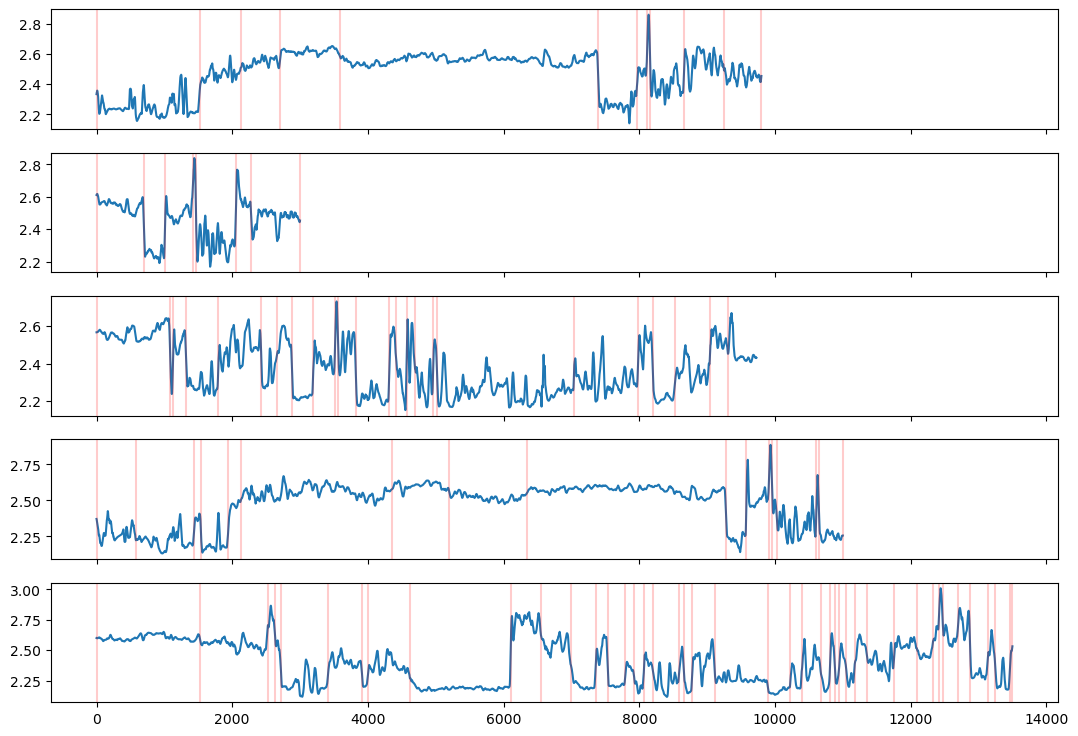

In [64]:
fig, ax = plt.subplots(5, figsize=[13, 9], sharex=True)

_log_choice = 'Roll_Avg_RHOB'
len(data_f1A[_log_extent_min[0]:_log_extent_max[0]])
ax[0].plot(np.arange(len(data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]])), data_f1A[_log_choice][_log_extent_min[0]:_log_extent_max[0]])
for i in f1A_RHOBbp:
    ax[0].axvline(i, c='r', alpha=0.2)
ax[1].plot(np.arange(len(data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]])), data_f1B[_log_choice][_log_extent_min[1]:_log_extent_max[1]])
for i in f1B_RHOBbp:
    ax[1].axvline(i, c='r', alpha=0.2)
ax[2].plot(np.arange(len(data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]])), data_f1C[_log_choice][_log_extent_min[2]:_log_extent_max[2]])
for i in f1C_RHOBbp:
    ax[2].axvline(i, c='r', alpha=0.2)
ax[3].plot(np.arange(len(data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]])), data_f11A[_log_choice][_log_extent_min[3]:_log_extent_max[3]])
for i in f11A_RHOBbp:
    ax[3].axvline(i, c='r', alpha=0.2)
ax[4].plot(np.arange(len(data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]])), data_f11B[_log_choice][_log_extent_min[4]:_log_extent_max[4]])
for i in f11B_RHOBbp:
    ax[4].axvline(i, c='r', alpha=0.2)

In [65]:
# Stacking breakpoint/trends from seach function for input into the correlation function.

cpf1A_RHOB = np.vstack((f1A_RHOBbp, f1A_RHOBmu))
cpf1B_RHOB = np.vstack((f1B_RHOBbp, f1B_RHOBmu))
cpf1C_RHOB = np.vstack((f1C_RHOBbp, f1C_RHOBmu))
cpf11A_RHOB = np.vstack((f11A_RHOBbp, f11A_RHOBmu))
cpf11B_RHOB = np.vstack((f11B_RHOBbp, f11B_RHOBmu))

cpf1A_PEF = np.vstack((f1A_PEFbp, f1A_PEFmu))
cpf1B_PEF = np.vstack((f1B_PEFbp, f1B_PEFmu))
cpf1C_PEF = np.vstack((f1C_PEFbp, f1C_PEFmu))
cpf11A_PEF = np.vstack((f11A_PEFbp, f11A_PEFmu))
cpf11B_PEF = np.vstack((f11B_PEFbp, f11B_PEFmu))

cpf1A_NPHI = np.vstack((f1A_NPHIbp, f1A_NPHImu))
cpf1B_NPHI = np.vstack((f1B_NPHIbp, f1B_NPHImu))
cpf1C_NPHI = np.vstack((f1C_NPHIbp, f1C_NPHImu))
cpf11A_NPHI = np.vstack((f11A_NPHIbp, f11A_NPHImu))
cpf11B_NPHI = np.vstack((f11B_NPHIbp, f11B_NPHImu))

cpf1A_GR = np.vstack((f1A_GRbp, f1A_GRmu))
cpf1B_GR = np.vstack((f1B_GRbp, f1B_GRmu))
cpf1C_GR = np.vstack((f1C_GRbp, f1C_GRmu))
cpf11A_GR = np.vstack((f11A_GRbp, f11A_GRmu))
cpf11B_GR = np.vstack((f11B_GRbp, f11B_GRmu))


In [66]:
f1B_11A_PEFcorr = cp_Comp.cpCorrelation(cpf1B_PEF, cpf11A_PEF)
f1C_11A_PEFcorr = cp_Comp.cpCorrelation(cpf1C_PEF, cpf11A_PEF)
f1A_11A_PEFcorr = cp_Comp.cpCorrelation(cpf1A_PEF, cpf11A_PEF)
f11B_11A_PEFcorr = cp_Comp.cpCorrelation(cpf11B_PEF, cpf11A_PEF)

*****MATCH1.0
*****MATCH0.9999810484903165
*****MATCH0.9999521538979643
*****MATCH0.9999729494298629
*****MATCH0.9999999531238337
*****MATCH0.999988743733523
*****MATCH0.9999936892875709
*****MATCH0.9999181388924
*****MATCH0.9999468787761667
*****MATCH0.9999574323493327
*****MATCH0.9999768801019425
*****MATCH1.0
*****MATCH0.9999692109125304
*****MATCH0.9999864909742207
*****MATCH0.999999711698983
*****MATCH0.9999589879076849
*****MATCH0.9999976667070846
*****MATCH0.9999894790802196
*****MATCH0.9999184799129925
*****MATCH0.9999465231176503
*****MATCH0.9999912904217714
*****MATCH0.9999984744930099
*****MATCH0.9999693206937413
*****MATCH0.9999247030737967
*****MATCH0.9999921023310983
*****MATCH0.9999563397266411
*****MATCH0.9999528475038666
*****MATCH0.9999427289003134
*****MATCH0.999901370935093
*****MATCH0.9999970296678016
*****MATCH0.9999999999455604
*****MATCH0.9999581129348987
*****MATCH0.9999773809580194
*****MATCH0.999902626321775
*****MATCH0.9999490313029409
*****MATCH0.9999739323

In [67]:
f1B_11A_NPHIcorr = cp_Comp.cpCorrelation(cpf1B_NPHI, cpf11A_NPHI)
f1C_11A_NPHIcorr = cp_Comp.cpCorrelation(cpf1C_NPHI, cpf11A_NPHI)
f1A_11A_NPHIcorr = cp_Comp.cpCorrelation(cpf1A_NPHI, cpf11A_NPHI)
f11B_11A_NPHIcorr = cp_Comp.cpCorrelation(cpf11B_NPHI, cpf11A_NPHI)

*****MATCH1.0
*****MATCH0.9999511847854785
*****MATCH0.9999994284634661
*****MATCH0.9999952162998744
*****MATCH0.9999830441110151
*****MATCH0.9999456926918603
*****MATCH0.9999776795989863
*****MATCH1.0
*****MATCH0.9999029822969757
*****MATCH0.9999956510210922
*****MATCH0.9999945382664237
*****MATCH0.9999990447364705
*****MATCH0.9999539364566185
*****MATCH0.9999823601450666
*****MATCH0.999948975737548
*****MATCH0.9999972863146551
*****MATCH0.9999962202268247
*****MATCH0.9999976371677284
*****MATCH0.9999393151343794
*****MATCH0.999978505073809
*****MATCH0.9999471397448194
*****MATCH0.9999629676544881
*****MATCH0.9999996130476139
*****MATCH1.0
*****MATCH0.9999862245545751
*****MATCH0.9999307512640616
*****MATCH0.9999994416726469
*****MATCH0.9999777578094838
*****MATCH0.999965070606945
*****MATCH0.9999471506631318
*****MATCH0.9999786068560538
*****MATCH0.9999987054561251
*****MATCH0.9999134955107316
*****MATCH0.9999523213184813
*****MATCH0.9999528020301314
*****MATCH1.0
*****MATCH0.9999650

In [68]:
f1B_11A_GRcorr = cp_Comp.cpCorrelation(cpf1B_GR, cpf11A_GR)
f1C_11A_GRcorr = cp_Comp.cpCorrelation(cpf1C_GR, cpf11A_GR)
f1A_11A_GRcorr = cp_Comp.cpCorrelation(cpf1A_GR, cpf11A_GR)
f11B_11A_GRcorr = cp_Comp.cpCorrelation(cpf11B_GR, cpf11A_GR)

*****MATCH1.0
*****MATCH0.9999918475947559
*****MATCH0.9999160359411854
*****MATCH0.9999998892104086
*****MATCH0.9999566116527383
*****MATCH0.999989374366317
*****MATCH0.9999910500993489
*****MATCH0.9999446336028542
*****MATCH1.0
*****MATCH0.9999994434167254
*****MATCH0.9999996003367322
*****MATCH0.999974179049126
*****MATCH0.9999542626917712
*****MATCH0.9999974785238438
*****MATCH0.9999782262806602
*****MATCH0.9999982072547117
*****MATCH1.0
*****MATCH0.9999931768817742
*****MATCH0.9999867355384554
*****MATCH0.9999999009392504
*****MATCH0.9999540259114383
*****MATCH0.9999902153822071
*****MATCH0.9999742424027964
*****MATCH0.9999976323447541
*****MATCH1.0
*****MATCH0.9999349054039492
*****MATCH0.9999998049135354
*****MATCH0.9999814283507744
*****MATCH0.9999635943930202
*****MATCH0.999999951409705
*****MATCH0.9999903473517778
*****MATCH0.9999769316315166
*****MATCH0.9999143977020477
*****MATCH0.999908979647937
*****MATCH0.9999580141355291
*****MATCH0.9999717002818371
*****MATCH0.99999012

In [69]:
f1B_11A_RHOBcorr = cp_Comp.cpCorrelation(cpf1B_RHOB, cpf11A_RHOB)
f1C_11A_RHOBcorr = cp_Comp.cpCorrelation(cpf1C_RHOB, cpf11A_RHOB)
f1A_11A_RHOBcorr = cp_Comp.cpCorrelation(cpf1A_RHOB, cpf11A_RHOB)
f11B_11A_RHOBcorr = cp_Comp.cpCorrelation(cpf11B_RHOB, cpf11A_RHOB)

*****MATCH1.0
*****MATCH0.999947660187267
*****MATCH0.9999993873491699
*****MATCH0.9999992828453932
*****MATCH0.9999774858256801
*****MATCH0.9999476907600462
*****MATCH0.9999991568382907
*****MATCH0.9999898585011232
*****MATCH0.999908658705045
*****MATCH0.999936338292223
*****MATCH0.9999946374764626
*****MATCH0.999999997561903
*****MATCH0.9999254115019237
*****MATCH0.9999996547558903
*****MATCH0.9999905431613911
*****MATCH0.9999742385687038
*****MATCH0.9999460967070902
*****MATCH0.9999374869846762
*****MATCH0.9999026596242983
*****MATCH0.9999650350927587
*****MATCH0.9999867360789174
*****MATCH1.0
*****MATCH0.999982072261846
*****MATCH0.9999656173089309
*****MATCH0.9999502639938269
*****MATCH0.9999767614724012
*****MATCH0.9999934755142924
*****MATCH0.9999719515630837
*****MATCH0.9999543537966237
*****MATCH0.999973818195847
*****MATCH0.9999918747136403
*****MATCH0.999973001262648
*****MATCH0.9999989428268039
*****MATCH0.9999807012364218
*****MATCH0.9999440500137121
*****MATCH0.9999728177

In [70]:
f11A_corrmatrix = cp_Comp.combine_vectors_to_matrix_(f1A_11A_NPHIcorr, f1C_11A_NPHIcorr, f11B_11A_NPHIcorr , f1B_11A_NPHIcorr,
                                                    f1B_11A_RHOBcorr,f1C_11A_RHOBcorr, f1A_11A_RHOBcorr, f11B_11A_RHOBcorr,
                                                    f1B_11A_GRcorr,f1C_11A_GRcorr, f1A_11A_GRcorr, f11B_11A_GRcorr,
                                                    f1B_11A_PEFcorr,f1C_11A_PEFcorr, f1A_11A_PEFcorr, f11B_11A_PEFcorr,)



rows  23381 columns 16


In [71]:
f11A_FM = {0:'Norland GP FM', 1:'Ty FM', 2:'Ekofisk FM', 3:'Hod FM', 4:'Draupne FM', 5:'Heather FM', 6:'Heather FM (Sand)', 7:'Hugin FM', 8:'Sleipner FM'}
f11A_color = {0:'r', 1:'g', 2:'purple', 3:'orange', 4:'yellow', 5:'grey', 6:'black', 7:'pink', 8:'blue'}
f11A_tops = np.array([2600, 2624,2794.5,3118,3525.8,3574.9,3585.2,3594.6,3702])

vectors = []

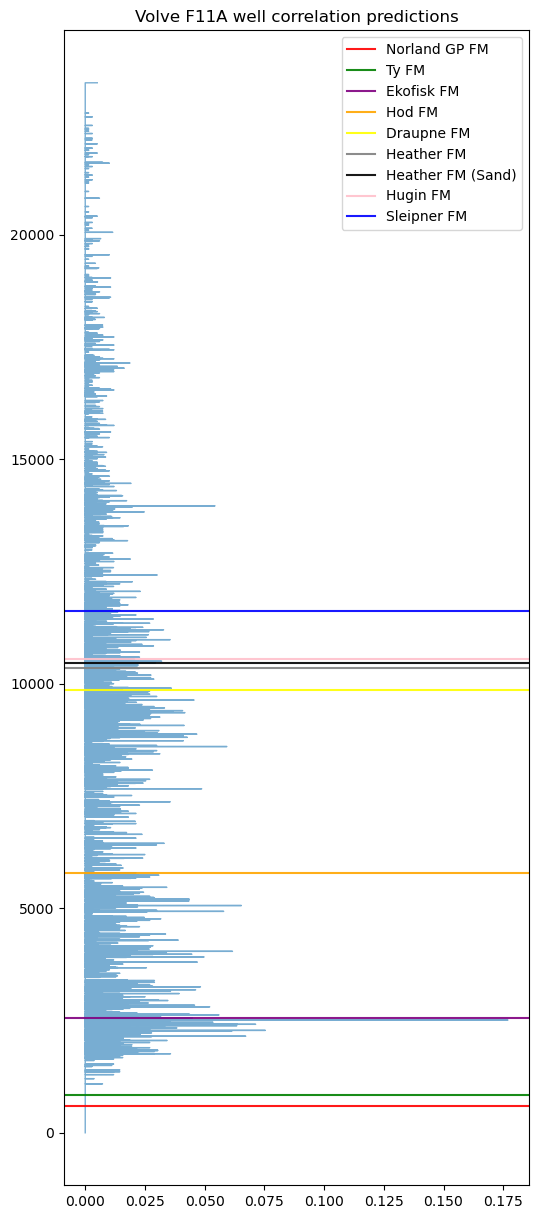

In [72]:
import matplotlib as mpl
#cmap = mpl.colormaps['']
plt.figure(figsize=(6,15))
plt.plot(np.sum(f11A_corrmatrix, axis=1), np.arange(len(f11A_corrmatrix)), linewidth=1, alpha=.6 )
maxx = len(data_f11A)
f11A_top10 = f11A_tops*10-25400
plt.title('Volve F11A well correlation predictions')
#f11A_top10
#cmap = plt.colormaps('turbo')
k=0
for i in f11A_top10:
    plt.axhline(i, alpha=0.9, color=f11A_color[k], label=f11A_FM[k])
    #print(k)
    k=k+1
plt.legend(loc='upper right')

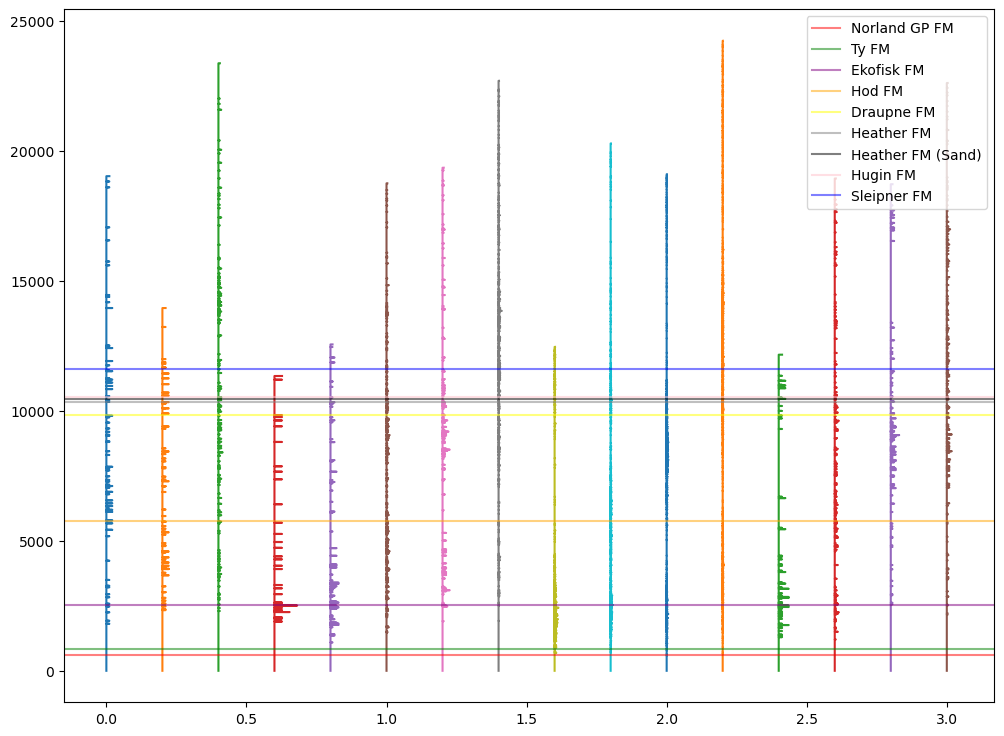

In [59]:
corrs = [f1A_11A_NPHIcorr, f1C_11A_NPHIcorr, f11B_11A_NPHIcorr , f1B_11A_NPHIcorr,
            f1B_11A_RHOBcorr,f1C_11A_RHOBcorr, f1A_11A_RHOBcorr, f11B_11A_RHOBcorr,
            f1B_11A_GRcorr,f1C_11A_GRcorr, f1A_11A_GRcorr, f11B_11A_GRcorr,
            f1B_11A_PEFcorr,f1C_11A_PEFcorr, f1A_11A_PEFcorr, f11B_11A_PEFcorr]
plt.figure(figsize=(12,9))
for i in range(len(corrs)):
    plt.plot(corrs[i]+i*0.2, np.arange(len(corrs[i])))
f11A_top10 = f11A_tops*10-25400  # subtracting 56 meters from the Formation tops because of well divergence. (This will need a more sophisticated solution)
#f11A_top10
#cmap = plt.colormaps('turbo')
k=0
for i in f11A_top10:
    plt.axhline(i, alpha=0.5, color=f11A_color[k], label=f11A_FM[k])
    #print(k)
    k=k+1
plt.legend(loc='upper right')